In [5]:
import pandas as pd

df = pd.read_csv("DisneylandReviews.csv", encoding="latin-1")
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


In [ ]:
import streamlit as st
import os
import pickle
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain 
from langchain.chains.qa_with_sources.loading import load_qa_with_sources_chain
from langchain.callbacks import get_openai_callback
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from PyPDF2 import PdfReader


st.write('# Mi GPT')

with st.sidebar:
    api_key_file = st.file_uploader('Sube aqui tu Key', 
                                    type=['txt'])
if api_key_file is not None:
    key = str(api_key_file.readline().decode('utf-8'))
    os.environ['OPENAI_API_KEY'] = key

    llm = ChatOpenAI(model_name='gpt-3.5-turbo')
    if pdf is not None:
        with st.status("Extrayendo texto...", expanded=True) as status:
            pdf_reader = PdfReader(pdf)
            text = ""
            for page in pdf_reader.pages:
                text+= page.extract_text()

            #langchain_textspliter
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size = 1000,
                chunk_overlap = 200,
                length_function = len
            )

            st.write('Creando chunks...')
            chunks = text_splitter.split_text(text=text)

        
        
            store_name = pdf.name[:-4]
        
            st.write('Buscando Vectorstore..')
            if os.path.exists(f"{store_name}.pkl"):
                with open(f"{store_name}.pkl","rb") as f:
                    vectorstore = pickle.load(f)
                st.write("Vector store existente. Cargando...")
            else:
                embeddings = OpenAIEmbeddings()
                vectorstore = FAISS.from_texts(chunks,embedding=embeddings)

                with open(f"{store_name}.pkl","wb") as f:
                    pickle.dump(vectorstore,f)
            
                st.write("Guardando embeddings en memoria...")

            status.update(label="Todo listo para hacer preguntas!", state="complete", expanded=False)

        query = st.text_input("Preguntale a tu PDF. Pica enter luego de escribir tu pregunta","EG: De que habla este documento")
        if query !="EG: De que habla este documento":
            with st.spinner('Trabajando en eso...'):
                docs = vectorstore.similarity_search(query=query,k=3)
                chain = load_qa_chain(llm=llm, chain_type= "stuff", verbose=True)
                with get_openai_callback() as cb:
                    response = chain.run(input_documents = docs, question = query)
                    print(cb)

                st.success(f'''
                    RESPUESTA:
                    {response}
                ''', icon="✅")

In [14]:
df["Rating"].value_counts()

Rating
5    23146
4    10775
3     5109
2     2127
1     1499
Name: count, dtype: int64

In [15]:
undersampled_data = pd.DataFrame(columns=["Rating","Review_Text","Branch"])

undersampled_data = pd.concat([undersampled_data, df[df["Rating"]==1].sample(1499)])
undersampled_data = pd.concat([undersampled_data, df[df["Rating"]==2].sample(1499)])
undersampled_data = pd.concat([undersampled_data, df[df["Rating"]==3].sample(1499)])
undersampled_data = pd.concat([undersampled_data, df[df["Rating"]==4].sample(1499)])
undersampled_data = pd.concat([undersampled_data, df[df["Rating"]==5].sample(1499)])
df = undersampled_data
df.reset_index(inplace=True)

In [16]:
undersampled_data

,index,Rating,Review_Text,Branch,Review_ID,Year_Month,Reviewer_Location
0,17206,1,I did not think it was possible to fit that ma...,Disneyland_California,321492245.0,2015-10,United States
1,5371,1,Visited with a friend and her two early teen k...,Disneyland_HongKong,317255829.0,2015-10,Hong Kong
2,20805,1,"This was an overpriced, run down, horror of a ...",Disneyland_California,233135824.0,2014-10,United States
3,5369,1,In short. Hong Kong Disney has nothing to offe...,Disneyland_HongKong,317352620.0,2015-10,South Africa
4,19067,1,I have been to Disneyland many times over the ...,Disneyland_California,275839736.0,2015-5,United States
...,...,...,...,...,...,...,...
7490,17020,5,"Being a bit of an old, boring dad, I wasn't ne...",Disneyland_California,326835775.0,2014-12,Australia
7491,4990,5,"I love Disney, but I hate crowds. It's an horr...",Disneyland_HongKong,334381190.0,2015-12,South Africa
7492,4425,5,"Best time to visit is starting Sunday morning,...",Disneyland_HongKong,361354183.0,2016-3,Indonesia
7493,13550,5,Always fun. The park is always so well mainta...,Disneyland_California,455785252.0,2017-1,United States


In [17]:
undersampled_data["Rating"].value_counts()

Rating
1    1499
2    1499
3    1499
4    1499
5    1499
Name: count, dtype: int64

In [18]:
import tensorflow as tf
if tf.test.gpu_device_name():
  print(f"se encontro el siguiente gpu{tf.test.gpu_device_name()}")
else:
  print("aqui no hau GPU")

aqui no hau GPU


In [19]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_lg")
doc = nlp("This is a Test")
doc

This is a Test

In [20]:
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
stop_words_en = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def vectorize(texto):
    resultado = texto.lower()
    stop_words_en.append("u")
    resultado = re.sub(r"@[A-Za-z0-9]+", "", resultado)
    resultado = re.sub(r"^[A-Za-z0-9 \t]+", "", resultado)
    resultado = re.sub(r"\w+:\/\/\S+", "", resultado)
    resultado = re.sub(r"rt", "", resultado)
    resultado = re.sub(r"(\s\s\s)|(\s\s)|(\-)|(\t)", " ", resultado) 
    resultado = word_tokenize(resultado)
    resultado = [token for token in resultado if token not in stop_words_en]
    resultado = [lemmatizer.lemmatize(word) for word in resultado]
    resultado = " ".join(resultado)
    resultado = nlp(resultado).vector

    return resultado

In [22]:
df["vector"]=df["Review_Text"].apply(vectorize)

In [23]:
from sklearn.model_selection import train_test_split
X = df["vector"]
X = np.concatenate(X,axis=0).reshape(-1,300)
y= df["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=101,stratify=y)

In [24]:
np.min(X_train)

-11.8186245

Aqui no hay GPU´s
Error reading the file with encoding: utf-8
File read successfully with encoding: ISO-8859-1


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorenzoreinoso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lorenzoreinoso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lorenzoreinoso/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seab

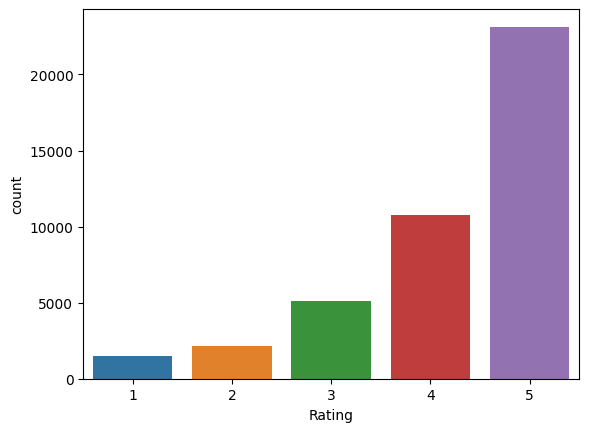

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


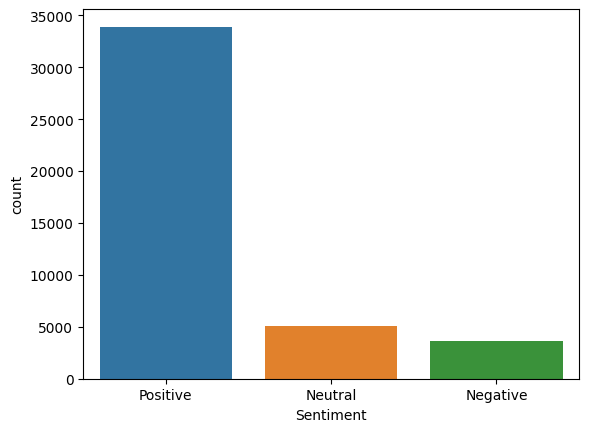

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'list'>

In [27]:
# -*- coding: utf-8 -*-
"""Proyecto_Disney.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1CrXeu9ffoViS4KvTKAJcle1qdhICd5oR
"""

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tfm
if tfm.test.gpu_device_name():
  print (f'Se encontró el siguientr GPU: {tfm.test.gpu_device_name()}')
else:
  print('Aqui no hay GPU´s')

encodings = ['utf-8', 'ISO-8859-1', 'latin1']

for encoding in encodings:
    try:
        df = pd.read_csv('DisneylandReviews.csv', encoding=encoding)
        print("File read successfully with encoding:", encoding)
        break
    except UnicodeDecodeError:
        print("Error reading the file with encoding:", encoding)
df.head()

df.isnull().sum()

df.duplicated().sum()

df.drop_duplicates(keep='first', inplace=True)

df['Reviewer_Location'].value_counts()

df['Reviewer_Location'].unique()

df['Rating'].value_counts()

df['Branch'].value_counts()

import re
import nltk
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocesamiento_texto(texto):

    # haces todo el texto en minúsculas
    texto=texto.lower()

    # regex para caracteres especiales y números
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)

    # tokenizar el texto
    texto_tokenized= word_tokenize(texto)

    # eliminar stopwords
    texto_no_stop = [token for token in texto_tokenized if token not in stop_words_en]

    # lematizar/unir las palabras procesadas nuevamente en una cadena
    final= [lemmatizer.lemmatize (word) for word in texto_no_stop]
    final=' '.join(final)

    return final

df['texto_limpio'] = df['Review_Text'].apply(preprocesamiento_texto)
df.head()

def sentiment(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

sns.countplot(x=df['Rating'])
plt.show()

sns.countplot(x=df['Sentiment'])
plt.show()

pos = df[df['Sentiment'] == 'Positive'].sample(3000)
neg = df[df['Sentiment'] == 'Negative'].sample(3000)
neu = df[df['Sentiment'] == 'Neutral'].sample(3000)

df = pd.concat([pos,neg,neu],axis=0)
df.shape

embeddings = {}
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_lg")
doc = nlp("This is a Test")

def vectorize(text):
    vector_size = 300
    texto = text.lower()
    texto = re.sub(r'[^a-zA-Z0-9\s]', '',texto)
    texto = word_tokenize(texto)
    texto = [palabra for palabra in texto if palabra not in stop_words_en]
    texto = [lemmatizer.lemmatize(palabra)for palabra in texto]
    vector = nlp(texto)
    return vector

df['vector']=df['Review_Text'].apply(vectorize)
df.head(10)

mapper={
    'Negative':0,
    'Neutral':1,
    'Positive':2,
}

df['Sentiment']= df['Sentiment'].map(mapper)
df.head()

from sklearn.model_selection import train_test_split

X_cnn = np.array(df['vector'].tolist())
y_cnn = df['Sentiment']

X_train_cnn,X_test_cnn,y_train_cnn,y_test_cnn = train_test_split(X_cnn,
                                                 y_cnn,
                                                 train_size=0.75,
                                                 random_state=101,
                                                 stratify=y_cnn)

y_test_cnn.shape

from sklearn.preprocessing import MinMaxScaler

scaler_cnn = MinMaxScaler()
X_train_cnn = scaler_cnn.fit_transform(X_train_cnn)
X_test_cnn = scaler_cnn.transform(X_test_cnn)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

early_stopping_cnn= EarlyStopping(monitor='val_loss',
                              patience=7,
                              restore_best_weights=True)

y_train_cnn

y_train_cnn=to_categorical(y_train_cnn,3)
y_test_cnn=to_categorical(y_test_cnn,3)

y_train_cnn.shape

y_train_cnn

X_train_cnn= X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1],1)
X_test_cnn= X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1],1)

model_cnn=Sequential()
model_cnn.add(Conv1D(32,2, activation='relu', input_shape=X_train_cnn[0].shape))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.35))
model_cnn.add(Dense(3, activation='softmax'))

model_cnn.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cnn=model_cnn.fit(X_train_cnn,
                  y_train_cnn,
                  epochs=100,
                  validation_data=(X_test_cnn, y_test_cnn),
                  callbacks=[early_stopping_cnn])

metrics_cnn=pd.DataFrame(history_cnn.history)
metrics_cnn.head()

import seaborn as sns
sns.lineplot(data=metrics_cnn[['loss', 'val_loss']])

sns.lineplot(data=metrics_cnn[['accuracy', 'val_accuracy']])

y_pred_cnn=model_cnn.predict(X_test_cnn)

y_pred_cnn=np.argmax(model_cnn.predict(X_test_cnn), axis=-1)
y_pred_cnn

y_test_cnn=np.argmax(y_test_cnn, axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_cnn, y_pred_cnn))

sns.heatmap(confusion_matrix(y_test_cnn, y_pred_cnn), annot=True, fmt='.0f')

def predict(text):
  text=vectorize(text)
  text=text.reshape(1,-1)
  text=scaler_cnn.transform(text)
  text=text.reshape(1,300,1)
  text=model_cnn.predict(text)
  print(f'''
    CATEGORY.             PROBABILITY
    _____________________________________
    Negative:             {text[0][0]}
    Neutral:              {text[0][1]}
    Positive:             {text[0][2]}

  ''')

neg='''
Disney Paris was a complete disappointment. The park was overcrowded, and the staff seemed indifferent to guests' experiences. The attractions were outdated and in desperate need of maintenance. The food was overpriced and of poor quality. Overall, a regrettable waste of time and money.
'''

predict(neg)

neutral='''
Disney Paris offered a mixed experience. The park had a diverse range of attractions catering to various age groups. While some staff members were helpful, others seemed disengaged. The park's cleanliness was acceptable, but there were moments of overcrowding. Food options were decent, though prices were on the higher side. Overall, a visit to Disney Paris may provide a moderate entertainment value depending on individual preferences.
'''
predict(neutral)

positive='''
Disney Paris provided a magical and enchanting experience. The park's attention to detail in recreating beloved Disney worlds was impressive. Staff members were friendly and went out of their way to enhance the guest experience. The attractions were well-maintained, and the entertainment options were diverse and captivating. The park's cleanliness and organization contributed to a seamless and enjoyable visit. From thrilling rides to charming character interactions, Disney Paris delivered a truly enchanting and memorable adventure for visitors of all ages.
'''

predict(positive)

import joblib
joblib.dump(model_cnn, 'modelo_cnn_chido.pkl')



# df = df.reset_index(drop=True)

# #FNNs
# from sklearn.model_selection import train_test_split

# X_fnn = df['vector']
# X_fnn = np.concatenate(X_fnn, axis=0).reshape(-1,300)
# y_fnn = df['Sentiment']

# X_train_fnn,X_test_fnn,y_train_fnn,y_test_fnn = train_test_split(X_fnn,
#                                                  y_fnn,
#                                                  train_size=0.80,
#                                                  random_state=10)

# df['Sentiment'].value_counts().plot(kind='bar')

# np.min(X_train_fnn)

# from sklearn.preprocessing import MinMaxScaler

# scaler_fnn= MinMaxScaler()

# X_train_fnn=scaler_fnn.fit_transform(X_train_fnn)
# X_test_fnn= scaler_fnn.transform(X_test_fnn)

# np.min(X_train_fnn)

# from keras.utils import to_categorical

# y_train_fnn = to_categorical(y_train_fnn, num_classes=3)
# y_test_fnn = to_categorical(y_test_fnn, num_classes=3)

# y_train_fnn

# from tensorflow import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping_fnn= EarlyStopping(monitor='val_loss',
#                                   patience=8,
#                                   restore_best_weights=True)

# model_fnn= Sequential()
# model_fnn.add(Dense(units=130, activation='relu', input_dim=X_fnn.shape[1]))
# model_fnn.add(Dense(units=130, activation='relu'))
# model_fnn.add(Dropout(0.2))
# model_fnn.add(Dense(units=130, activation='relu'))
# model_fnn.add(Dropout(0.3))
# model_fnn.add(Dense(units=3, activation='softmax'))

# model_fnn.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# history_fnn= model_fnn.fit(X_train_fnn,
#                    y_train_fnn,
#                    batch_size=4,
#                    epochs=100,
#                    validation_data=(X_test_fnn, y_test_fnn),
#                    callbacks=[early_stopping_fnn])

# metrics_fnn= pd.DataFrame(history_fnn.history)
# metrics_fnn.head()

# import seaborn as sns
# sns.lineplot(data=metrics_fnn[['loss', 'val_loss']])

# sns.lineplot(data=metrics_fnn[['accuracy', 'val_accuracy']])

# y_pred_fnn=np.argmax(model_fnn.predict(X_test_fnn), axis=-1)
# y_pred_fnn

# y_test_fnn=np.argmax(y_test_fnn, axis=-1)
# print(y_test_fnn.shape)

# umbral= 0.5
# y_pred_fnn= np.where(y_pred_fnn>umbral, 1,0)
# y_pred_fnn

# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(y_test_fnn, y_pred_fnn))

# sns.heatmap(confusion_matrix(y_test_fnn, y_pred_fnn), annot=True, fmt='.0f')

In [38]:
def predecir_sentimiento_R(texto):
    texto_limpo = vectorize(texto)
    prediccion = model.predict(texto_limpo)
    return prediccion[0]

texto ='''
Disney Paris provided a magical and enchanting experience. The park's attention to detail in recreating beloved Disney worlds was impressive. Staff members were friendly and went out of their way to enhance the guest experience. The attractions were well-maintained, and the entertainment options were diverse and captivating. The park's cleanliness and organization contributed to a seamless and enjoyable visit. From thrilling rides to charming character interactions, Disney Paris delivered a truly enchanting and memorable adventure for visitors of all ages.
'''

predictionLR = predecir_sentimiento_R(texto)

No hay un embedding para la palabra wellmaintained. Omitiendo...


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [51]:
import pickle
with open('modelo_cnn_chido.pkl', 'rb') as file:
    model = pickle.load(file)
model.summary()
print("Expected Input Shape:", model.input_shape)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 299, 32)           96        
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 149, 32)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4768)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                305216    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                      

In [52]:
with open('/Users/lorenzoreinoso/Documents/Files/glove.6B.300d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:])
        embeddings[word] = vectors

def vectorize(text):
    vector_size = 300
    texto = text.lower()
    texto = re.sub(r'[^a-zA-Z0-9\s]', '',texto)
    texto = word_tokenize(texto)
    texto = [palabra for palabra in texto if palabra not in stop_words_en]
    texto = [lemmatizer.lemmatize(palabra)for palabra in texto]
    vector = np.zeros(vector_size)
    for palabra in texto:
        if palabra in embeddings:
            vector = vector + embeddings[palabra].astype('float')
        else:
            print(f"No hay un embedding para la palabra {palabra}. Omitiendo...")
    vector = vector.reshape(1, 300, 1)
    return vector

texto = "i realy love to make pancakes and play videogames in the morning"

vector = vectorize(texto)

In [57]:
def predecir_sentimiento_R(texto):
    texto_limpo = vectorize(texto)
    prediccion = model.predict(texto_limpo)
    return prediccion[0]

texto ='''
Disney Paris provided a magical and enchanting experience. The park's attention to detail in recreating beloved Disney worlds was impressive. Staff members were friendly and went out of their way to enhance the guest experience. The attractions were well-maintained, and the entertainment options were diverse and captivating. The park's cleanliness and organization contributed to a seamless and enjoyable visit. From thrilling rides to charming character interactions, Disney Paris delivered a truly enchanting and memorable adventure for visitors of all ages.
'''

predictionLR = predecir_sentimiento_R(texto)

print("Actual Input Shape:", vector.shape)


No hay un embedding para la palabra wellmaintained. Omitiendo...
1/1 [==============================] - 0s 19ms/step
Actual Input Shape: (1, 300, 1)


In [60]:
print(predictionLR)
print(f'''
    CATEGORY.             PROBABILITY
    _____________________________________
    Negative:             {predictionLR[0]}
    Neutral:              {predictionLR[1]}
    Positive:             {predictionLR[2]}

  ''')

[0.13036895 0.4366236  0.43300745]

    CATEGORY.             PROBABILITY
    _____________________________________
    Negative:             0.13036894798278809
    Neutral:              0.43662360310554504
    Positive:             0.43300744891166687

  
